# Anime Recommender (pt 1 - Nearest Neighbors)

Welcome to part 1 of my anime recommender. Here I will create a preliminary anime recommendation system using the KNeighbors approach. I'll tackle the problem in greater detail in part 2 using collaborative filtering.

Let's begin by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

## The Data

In part 1, we work with just the anime.csv database. Let's view the data.

In [2]:
df = pd.read_csv('anime.csv')
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

### Dealing with missing values

'genre' and 'type' can be dealt with by replacing missing values with 'None'. For 'rating', I will populate missing value with the column's median value. Lastly for 'episodes', there are a several values labeled as 'Unknown' (many anime were still airing at the time of this dataset's creation, or were simply not entered properly in myanimelist.net's database). To deal with this, I'll replace the 'Unknown' values with median of the 'episodes' column. 

In [4]:
df['type'] = df['type'].fillna('None')
df['genre'] = df['genre'].fillna('None')
df['rating'] = df['rating'].fillna(df['rating'].median())
episode_ = df['episodes'].replace('Unknown', np.nan)
episode_ = episode_.fillna(episode_.median())
df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

### Famous genres

Before moving forward, I would like to explore the most popular genres for anime. Let's create a wordcloud to visualize this.

(-0.5, 699.5, 740.5, -0.5)

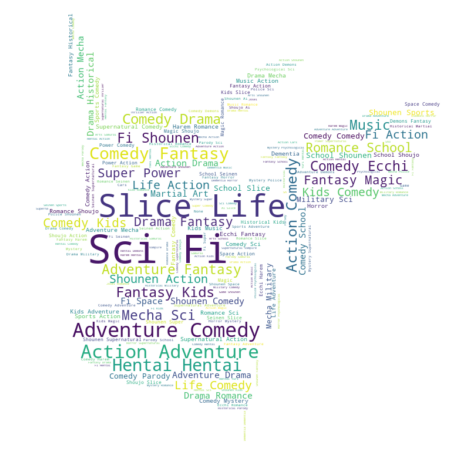

In [5]:
genre_list = df['genre'].to_string()
pikachu = np.array(Image.open('pikachu.jpg'))
wordcloud = WordCloud(background_color="white", mask=pikachu).generate(genre_list)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Yes.. it's a Pikachu.

Looks like Sci Fi and Slice of Life are the most famous genres. A great example of an anime that combines these two styles is [Uchuu Kyoudai (Space Brothers)](https://myanimelist.net/anime/12431/Uchuu_Kyoudai). It follows two brothers on their journey in becoming astronauts. Currently sitting at 8.58/10 rated by over 20,000 users, it is  must watch for any sci-fi fan.

<img src="notebook_images/space_brothers.jpg">

### Feature processing

Before building a feature matrix, it is important to deal with categorical variables such as 'title' and 'genre'. Let's introduce dummy variables.

In [6]:
type_ = pd.get_dummies(df['type'])
genre_ = df['genre'].str.get_dummies(sep=',')
genre_.head()

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Due to dummy coding, we can see above that the second anime is (at least) an Adventure/Drama/Fantasy type.

In [7]:
X = pd.concat([genre_, type_, episode_, df['rating'], df['members']],axis=1)
X.head()

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Movie,Music,None,ONA,OVA,Special,TV,episodes,rating,members
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,9.37,200630
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,64,9.26,793665
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,51,9.25,114262
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,24,9.17,673572
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,51,9.16,151266


Notice that 'episodes' and 'members' columns contain values much larger than the rest of the dataset, so let's scale our features.

In [8]:
scaled = MaxAbsScaler()
X = scaled.fit_transform(X)

## KNeighbors

Let's create the model. I want the model to recommend 10 anime similar to the queried anime, so let's set n_neighbors to 11 (to account for the inclusion of the queried anime within the neighborhood). 

In [9]:
recommendations = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(X)
recommendations.kneighbors(X)

(array([[  0.00000000e+00,   1.01506549e+00,   1.03095542e+00, ...,
           1.45773221e+00,   1.45854509e+00,   1.45930354e+00],
        [  0.00000000e+00,   1.02227158e+00,   1.49378838e+00, ...,
           1.65016556e+00,   1.74844630e+00,   1.78151418e+00],
        [  0.00000000e+00,   3.75894154e-02,   4.12559430e-02, ...,
           1.42104554e+00,   1.42183188e+00,   1.42808851e+00],
        ..., 
        [  0.00000000e+00,   1.66436926e-03,   1.68253094e-03, ...,
           8.07869678e-03,   1.01353307e-02,   1.11230973e-02],
        [  0.00000000e+00,   1.00174940e-03,   1.10513608e-03, ...,
           4.01486740e-03,   5.00190620e-03,   5.03023042e-03],
        [  0.00000000e+00,   1.00179958e+00,   1.41421365e+00, ...,
           1.41421400e+00,   1.41421404e+00,   1.41421417e+00]]),
 array([[    0,   208,  1494, ...,  5796,  5697,  5805],
        [    1,   200,   268, ...,  6868,   288,   374],
        [    2,     4,     9, ...,   216,   306,  1833],
        ..., 
       

In [10]:
anime_indices = recommendations.kneighbors(X)[1] # picks off the array for anime indices

We finally define functions to help display the results of our KNN model. Note that recommend_me function will only input exact names of anime as seen on [myanimelist.net](https://myanimelist.net/).

In [11]:
def get_index(x):
    # gives index for the anime
    return df[df['name']==x].index.tolist()[0]

In [12]:
def recommend_me(anime):
    print('Here are 10 anime similar to', anime, ':' '\n')
    index = get_index(anime)
    
    # ignore first entry so as to not return the queried anime as similar to itself
    for i in anime_indices[index][1:]:
            print(df.iloc[i]['name'], 
                  '\n' 'Genre: ', df.iloc[i]['genre'],
                  '\n' 'Episode count: ', df.iloc[i]['episodes'],
                  '\n' 'Rating out of 10:', df.iloc[i]['rating'], '\n')

### Example
<br>
<img src="notebook_images/death_note.jpg">

In [13]:
recommend_me('Death Note')

Here are 10 anime similar to Death Note :

Higurashi no Naku Koro ni Kai 
Genre:  Mystery, Psychological, Supernatural, Thriller 
Episode count:  24 
Rating out of 10: 8.41 

Death Note Rewrite 
Genre:  Mystery, Police, Psychological, Supernatural, Thriller 
Episode count:  2 
Rating out of 10: 7.84 

Jigoku Shoujo Mitsuganae 
Genre:  Mystery, Psychological, Supernatural 
Episode count:  26 
Rating out of 10: 7.81 

Yakushiji Ryouko no Kaiki Jikenbo 
Genre:  Mystery, Police, Supernatural 
Episode count:  13 
Rating out of 10: 7.19 

Saint Luminous Jogakuin 
Genre:  Mystery, Psychological, Supernatural 
Episode count:  13 
Rating out of 10: 6.17 

Boku dake ga Inai Machi 
Genre:  Mystery, Psychological, Seinen, Supernatural 
Episode count:  12 
Rating out of 10: 8.65 

Shiki 
Genre:  Mystery, Supernatural, Thriller, Vampire 
Episode count:  22 
Rating out of 10: 7.99 

Mousou Dairinin 
Genre:  Drama, Mystery, Police, Psychological, Supernatural, Thriller 
Episode count:  13 
Rating out 

## Conclusion

Having seen most of these anime, I can attest to the fact that they are similar to Death Note in at least tone/mood.

However, users on [myanimelist.net](https://myanimelist.net/) are able to make their own recommendations:

<img src="notebook_images/user_voted.JPG">

Now these anime are much closer in similarity to Death Note. The reason our method described above did not return the most optimum results is due greatly to the fact that we ignored the rating.csv dataset. This dataset is essentially user preference data - if users have seen and enjoyed Death Note, what else are they inclined to like? 

I will tackle this problem using content-based collaborative filtering in 'Anime Recommender (pt 2 - CLF)'.